# 4DOF Cart-Pole System Model - Position

Theoretical mathematical model of the 4DOF cart-pole system in the coordinate system $ (x, y, \theta, \varphi) $ with external normal velocity as free variable.

Dynamic model uses Euler-Lagrange equations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from IPython.display import display, Math, Latex
from scipy.integrate import solve_ivp
from sksundae.ida import IDA

 ## Model

In [2]:
t = sp.symbols(r't')

v = sp.Function(r'v')(t)

x = sp.Function(r'x')(t)
y = sp.Function(r'y')(t)
theta = sp.Function(r'\theta')(t)
phi = sp.Function(r'\varphi')(t)

x_dot = x.diff(t)
y_dot = y.diff(t)
theta_dot = theta.diff(t)
phi_dot = phi.diff(t)

x_ddot = x_dot.diff(t)
y_ddot = y_dot.diff(t)
theta_ddot = theta_dot.diff(t)
phi_ddot = phi_dot.diff(t)

plane_dir = sp.Matrix([sp.cos(phi), sp.sin(phi), 0])

dof = 4
q = sp.Matrix([x, y, theta, phi])
qd = sp.Matrix([x_dot, y_dot, theta_dot, phi_dot])
qdd = sp.Matrix([x_ddot, y_ddot, theta_ddot, phi_ddot])

args = [t, x, x_dot, y, y_dot, theta, theta_dot, phi, phi_dot]

In [3]:
# Constants
sp_half = sp.Rational(1, 2)

# Define symbols
hb, hr, hbc, eb, ew, dw = sp.symbols(r'h_b, h_r, h_bc, e_b, e_w, d_w', constant=True)
m, Ir, Iz, Iw, ba, bd, ct, rho, g = sp.symbols(r'm, I_r, I_z, I_w, b_a, b_d, c_{\theta}, \rho, g', constant=True)

params = [
    hbc,  # height of body center
    hb,  # height of body
    eb,  # body width
    dw,  # wheel diameter
    m,  # mass in kg
    Ir,  # moment of inertia
    Iz,  # moment of inertia
    Iw,  # moment of inertia
    ba,  # damping coefficient
    bd,  # drag coefficient
    ct,  # theta_dot correction factor, ideally sp.tanh(theta_dot - (omega_l + omega_r))
    rho,  # air density
    g,  # gravity in m/s^2
    v,  # normal velocity of the cart's origin, free variable
]

### Kinematic model

#### Kinematics of the body's origin

In [4]:
Xo = sp.Function('X_o')(t)

In [5]:
Xo = sp.Matrix([
    x,  # + sp.integrate(v * sp.cos(phi), (t, 0, t)),
    y,  # + sp.integrate(v * sp.sin(phi), (t, 0, t)),
    0,
])

# Lambdify
Xo_fn = sp.lambdify(args + params, Xo)

# Output
Xo = sp.simplify(Xo)
display(Xo)

Matrix([
[x(t)],
[y(t)],
[   0]])

In [6]:
Xo_dot = Xo.diff(t) + v * plane_dir

# Lambdify
Xo_dot_fn = sp.lambdify(args + params, Xo_dot)

# Output
Xo_dot = sp.simplify(Xo_dot)
display(Xo_dot)

Matrix([
[v(t)*cos(\varphi(t)) + Derivative(x(t), t)],
[v(t)*sin(\varphi(t)) + Derivative(y(t), t)],
[                                         0]])

#### Kinematics of the body's left wheel

In [7]:
Xlo = sp.Function('X_{l,o}')(t)
Xl = sp.Function('X_l')(t)

In [8]:
Xlo = sp.rot_givens(1, 0, phi) * sp.Matrix([0, eb, 0])
Xl = Xo + Xlo

# Output
Xl = sp.simplify(Xl)
display(Xl)

Matrix([
[-e_b*sin(\varphi(t)) + x(t)],
[ e_b*cos(\varphi(t)) + y(t)],
[                          0]])

In [9]:
Xl_dot = Xo_dot + Xlo.diff(t)

# Output
Xl_dot = sp.simplify(Xl_dot)
display(Xl_dot)

Matrix([
[-e_b*cos(\varphi(t))*Derivative(\varphi(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t)],
[-e_b*sin(\varphi(t))*Derivative(\varphi(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t)],
[                                                                                          0]])

In [10]:
Xl_dot_norm = sp.sqrt(Xl_dot.dot(Xl_dot))

# Output
Xl_dot_norm = sp.simplify(Xl_dot_norm)
display(Xl_dot_norm)

sqrt((-e_b*sin(\varphi(t))*Derivative(\varphi(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))**2 + (-e_b*cos(\varphi(t))*Derivative(\varphi(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))**2)

In [11]:
omega_l = 2 * Xl_dot_norm / dw - theta_dot

# Output
omega_l = sp.simplify(omega_l)
display(omega_l)

-Derivative(\theta(t), t) + 2*sqrt((-e_b*sin(\varphi(t))*Derivative(\varphi(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))**2 + (-e_b*cos(\varphi(t))*Derivative(\varphi(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))**2)/d_w

#### Kinematics of the body's right wheel

In [12]:
Xro = sp.Function('X_{r,o}')(t)
Xr = sp.Function('X_r')(t)

In [13]:
Xro = sp.rot_givens(1, 0, phi) * sp.Matrix([0, -eb, 0])
Xr = Xo + Xro

# Output
Xr = sp.simplify(Xr)
display(Xr)

Matrix([
[ e_b*sin(\varphi(t)) + x(t)],
[-e_b*cos(\varphi(t)) + y(t)],
[                          0]])

In [14]:
Xr_dot = Xo_dot + Xro.diff(t)

# Output
Xr_dot = sp.simplify(Xr_dot)
display(Xr_dot)

Matrix([
[e_b*cos(\varphi(t))*Derivative(\varphi(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t)],
[e_b*sin(\varphi(t))*Derivative(\varphi(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t)],
[                                                                                         0]])

In [15]:
Xr_dot_norm = sp.sqrt(Xr_dot.dot(Xr_dot))

# Output
Xr_dot_norm = sp.simplify(Xr_dot_norm)
display(Xr_dot_norm)

sqrt((e_b*sin(\varphi(t))*Derivative(\varphi(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))**2 + (e_b*cos(\varphi(t))*Derivative(\varphi(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))**2)

In [16]:
omega_r = 2 * Xr_dot_norm / dw - theta_dot

# Output
omega_r = sp.simplify(omega_r)
display(omega_r)

-Derivative(\theta(t), t) + 2*sqrt((e_b*sin(\varphi(t))*Derivative(\varphi(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))**2 + (e_b*cos(\varphi(t))*Derivative(\varphi(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))**2)/d_w

#### Kinematics of the body's center of mass

In [17]:
Xco = sp.Function('X_c')(t)
Xc = sp.Function('X_c')(t)

In [18]:
Xco = sp.rot_givens(1, 0, phi) * (sp.rot_givens(0, 2, theta) * sp.Matrix([0, 0, hbc]))
Xc = Xo + Xco

# Lambdify
Xc_fn = sp.lambdify(args + params, Xc)

# Output
Xc = sp.simplify(Xc)
display(Xc)

Matrix([
[h_bc*sin(\theta(t))*cos(\varphi(t)) + x(t)],
[h_bc*sin(\theta(t))*sin(\varphi(t)) + y(t)],
[                       h_bc*cos(\theta(t))]])

In [19]:
# TODO: Analyze the correct approach to Xc_dot

# Xc_dot = Xo_dot + Xco.diff(t)

omegao = sp.Matrix([
    0,
    theta_dot,
    phi_dot,
])

omegac = sp.rot_givens(1, 0, phi) * (sp.rot_givens(0, 2, theta) * omegao)
Xc_dot = Xo_dot + omegac.cross(Xco)

# Lambdify
Xc_dot_fn = sp.lambdify(args + params, Xc_dot)

# Output
Xc_dot = sp.simplify(Xc_dot)
display(Xc_dot)

Matrix([
[h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t)],
[h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t)],
[                                                            -h_bc*sin(\theta(t))*Derivative(\theta(t), t)]])

In [20]:
Xc_dot_norm = sp.sqrt(Xc_dot.dot(Xc_dot))

# Output
Xc_dot_norm = sp.simplify(Xc_dot_norm)
display(Xc_dot_norm)

sqrt(h_bc**2*sin(\theta(t))**2*Derivative(\theta(t), t)**2 + (h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))**2 + (h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))**2)

### Dynamic model

#### Kinect energy of the body

Assuming the hypothesis $ \frac{ 2 ||\dot{X_l}|| }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [21]:
T = (
        sp_half * m * Xc_dot_norm ** 2
        + sp_half * Ir * theta_dot ** 2
        + sp_half * (Iz + m * (hbc * sp.sin(theta)) ** 2) * phi_dot ** 2
        + sp_half * Iw * ((omega_l + theta_dot) ** 2 + (omega_r + theta_dot) ** 2 + ct * 2 * theta_dot ** 2)
)

# Output
T_exp = sp.expand(T)
T = sp.simplify(T_exp)
display(T)

I_r*Derivative(\theta(t), t)**2/2 + I_w*c_{\theta}*Derivative(\theta(t), t)**2 + 4*I_w*e_b**2*Derivative(\varphi(t), t)**2/d_w**2 + 4*I_w*v(t)**2/d_w**2 + 8*I_w*v(t)*sin(\varphi(t))*Derivative(y(t), t)/d_w**2 + 8*I_w*v(t)*cos(\varphi(t))*Derivative(x(t), t)/d_w**2 + 4*I_w*Derivative(x(t), t)**2/d_w**2 + 4*I_w*Derivative(y(t), t)**2/d_w**2 + I_z*Derivative(\varphi(t), t)**2/2 + h_bc**2*m*sin(\theta(t))**2*Derivative(\varphi(t), t)**2/2 + h_bc**2*m*Derivative(\theta(t), t)**2/2 + h_bc*m*v(t)*cos(\theta(t))*Derivative(\theta(t), t) + h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(y(t), t) + h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)*Derivative(x(t), t) + m*v(t)**2/2 + m*v(t)*sin(\varphi(t))*Derivative(y(t), t) + m*v(t)*cos(\varphi(t))*Derivative(x(t), t) + m*Derivative(x(t), t)**2/2 + m*Derivative(y(t), t)**2/2

In [22]:
T_gradq = sp.Matrix([
    T_exp.diff(x),
    T_exp.diff(y),
    T_exp.diff(theta),
    T_exp.diff(phi),
])

# Output
T_gradq_exp = sp.expand(T_gradq)
T_gradq = sp.simplify(T_gradq_exp)
display(T_gradq)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                0],
[                                                                                                                                                                                                                                                                                                                                                                                0],
[                                                                                                                                           h_bc*m*(h_bc*cos(\theta(t))*Derivative(\varphi(t), t)**2 - v(t)*Derivative(\theta(t), t) - sin(\varphi(t)

In [23]:
T_gradqd = sp.Matrix([
    T_exp.diff(x_dot),
    T_exp.diff(y_dot),
    T_exp.diff(theta_dot),
    T_exp.diff(phi_dot),
])

# Output
T_gradqd_exp = sp.expand(T_gradqd)
T_gradqd = sp.simplify(T_gradqd_exp)
display(T_gradqd)

Matrix([
[                                                                            (8*I_w*v(t)*cos(\varphi(t)) + 8*I_w*Derivative(x(t), t) + d_w**2*m*(h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t)))/d_w**2],
[                                                                            (8*I_w*v(t)*sin(\varphi(t)) + 8*I_w*Derivative(y(t), t) + d_w**2*m*(h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t)))/d_w**2],
[I_r*Derivative(\theta(t), t) + 2*I_w*c_{\theta}*Derivative(\theta(t), t) + h_bc**2*m*Derivative(\theta(t), t) + h_bc*m*v(t)*cos(\theta(t)) + h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t) + h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(x(t), t)],
[                                                                                                                                                                 (8*I_w*e_b**2 + I_z*d_w**2 + d_w**2*h_bc**2

In [24]:
T_gradqd_dot = T_gradqd_exp.diff(t)

# Output
T_gradqd_dot_exp = sp.expand(T_gradqd_dot)
T_gradqd_dot = sp.simplify(T_gradqd_dot_exp)
display(T_gradqd_dot)

Matrix([
[                                                                                                                                                                                                              (-8*I_w*v(t)*sin(\varphi(t))*Derivative(\varphi(t), t) + 8*I_w*cos(\varphi(t))*Derivative(v(t), t) + 8*I_w*Derivative(x(t), (t, 2)) + d_w**2*m*(-h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 - h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) + h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), (t, 2)) - v(t)*sin(\varphi(t))*Derivative(\varphi(t), t) + cos(\varphi(t))*Derivative(v(t), t) + Derivative(x(t), (t, 2))))/d_w**2],
[                                                                                                                                                                                                               (8*I_w*v(t)*cos(\varphi(t))*Derivative(\varphi(t), t) + 8*I_w*sin(\varphi(t))*Derivat

#### Potential energy of the body

In [25]:
V = m * g * Xc.dot(sp.Matrix([0, 0, 1]))

# Output
V = sp.simplify(V)
display(V)

g*h_bc*m*cos(\theta(t))

In [26]:
V_gradq = sp.Matrix([
    V.diff(x),
    V.diff(y),
    V.diff(theta),
    V.diff(phi),
])

# Output
V_gradq = sp.simplify(V_gradq)
display(V_gradq)

Matrix([
[                       0],
[                       0],
[-g*h_bc*m*sin(\theta(t))],
[                       0]])

In [27]:
V_gradqd = sp.Matrix([
    V.diff(x_dot),
    V.diff(y_dot),
    V.diff(theta_dot),
    V.diff(phi_dot),
])

# Output
V_gradqd = sp.simplify(V_gradqd)
display(V_gradqd)

Matrix([
[0],
[0],
[0],
[0]])

In [28]:
V_gradqd_dot = V_gradqd.diff(t)

# Output
V_gradqd_dot = sp.simplify(V_gradqd_dot)
display(V_gradqd_dot)

Matrix([
[0],
[0],
[0],
[0]])

#### Dissipation energy of the body

Assuming the hypothesis of no slip, then the dissipation from the wheel-ground contact $ D_w $ is zero.

Dissipation from the axle $ D_a $.

Assuming the hypothesis $ \frac{ 2 ||\dot{X_l}|| }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [29]:
Da = sp_half * ba * (
        (omega_l + theta_dot) ** 2
        + (omega_r + theta_dot) ** 2
        + ct * 2 * theta_dot ** 2
)

# Output
Da_exp = sp.expand(Da)
Da = sp.simplify(Da_exp)
display(Da)

b_a*(c_{\theta}*d_w**2*Derivative(\theta(t), t)**2 + 4*e_b**2*Derivative(\varphi(t), t)**2 + 4*v(t)**2 + 8*v(t)*sin(\varphi(t))*Derivative(y(t), t) + 8*v(t)*cos(\varphi(t))*Derivative(x(t), t) + 4*Derivative(x(t), t)**2 + 4*Derivative(y(t), t)**2)/d_w**2

In [30]:
D = Da

# Output
D = sp.simplify(D)
display(D)

b_a*(c_{\theta}*d_w**2*Derivative(\theta(t), t)**2 + 4*e_b**2*Derivative(\varphi(t), t)**2 + 4*v(t)**2 + 8*v(t)*sin(\varphi(t))*Derivative(y(t), t) + 8*v(t)*cos(\varphi(t))*Derivative(x(t), t) + 4*Derivative(x(t), t)**2 + 4*Derivative(y(t), t)**2)/d_w**2

In [31]:
D_gradq = sp.Matrix([
    D.diff(x),
    D.diff(y),
    D.diff(theta),
    D.diff(phi),
])

# Output
D_gradq = sp.simplify(D_gradq)
display(D_gradq)

Matrix([
[                                                                                             0],
[                                                                                             0],
[                                                                                             0],
[8*b_a*(-sin(\varphi(t))*Derivative(x(t), t) + cos(\varphi(t))*Derivative(y(t), t))*v(t)/d_w**2]])

In [32]:
D_gradqd = sp.Matrix([
    D.diff(x_dot),
    D.diff(y_dot),
    D.diff(theta_dot),
    D.diff(phi_dot),
])

# Output
D_gradqd = sp.simplify(D_gradqd)
display(D_gradqd)

Matrix([
[8*b_a*(v(t)*cos(\varphi(t)) + Derivative(x(t), t))/d_w**2],
[8*b_a*(v(t)*sin(\varphi(t)) + Derivative(y(t), t))/d_w**2],
[                2*b_a*c_{\theta}*Derivative(\theta(t), t)],
[            8*b_a*e_b**2*Derivative(\varphi(t), t)/d_w**2]])

#### External forces

Air drag $ E_d $ with executed work $ Q_d $. Assuming the hypothesis of the air relative velocity being small, we can take the first-order approximation $ x^2 \approx x $.

In [33]:
Xair_dot = Xc_dot + hbc * theta_dot * sp.Matrix([sp.sin(theta) * sp.cos(phi), sp.sin(theta) * sp.sin(phi), sp.cos(theta)])
Xair_dot = Xc_dot
Ed = - sp_half * rho * bd * Xair_dot

# Output
Ed = sp.simplify(Ed)
display(Ed)

Matrix([
[-\rho*b_d*(h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))/2],
[-\rho*b_d*(h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))/2],
[                                                                \rho*b_d*h_bc*sin(\theta(t))*Derivative(\theta(t), t)/2]])

In [34]:
Qd_gradq = sp.Matrix([
    Ed.dot(Xc.diff(x)),
    Ed.dot(Xc.diff(y)),
    Ed.dot(Xc.diff(theta)),
    Ed.dot(Xc.diff(phi)),
])

# Output
Qd_gradq = sp.simplify(Qd_gradq)
display(Qd_gradq)

Matrix([
[                                                         -\rho*b_d*(h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))/2],
[                                                         -\rho*b_d*(h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))/2],
[-\rho*b_d*h_bc*(h_bc*Derivative(\theta(t), t) + v(t)*cos(\theta(t)) + sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t) + cos(\theta(t))*cos(\varphi(t))*Derivative(x(t), t))/2],
[                                                                      \rho*b_d*h_bc*(sin(\varphi(t))*Derivative(x(t), t) - cos(\varphi(t))*Derivative(y(t), t))*sin(\theta(t))/2]])

In [35]:
Q_gradq = Qd_gradq
Q_gradq

Matrix([
[                                                         -\rho*b_d*(h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))/2],
[                                                         -\rho*b_d*(h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + v(t)*sin(\varphi(t)) + Derivative(y(t), t))/2],
[-\rho*b_d*h_bc*(h_bc*Derivative(\theta(t), t) + v(t)*cos(\theta(t)) + sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t) + cos(\theta(t))*cos(\varphi(t))*Derivative(x(t), t))/2],
[                                                                      \rho*b_d*h_bc*(sin(\varphi(t))*Derivative(x(t), t) - cos(\varphi(t))*Derivative(y(t), t))*sin(\theta(t))/2]])

#### Constraints

The constraints are applied using Lagrange multipliers and Baumgarte stabilization to avoid numerical drift.

Constraints:
- $ z_{wheel} \ge \frac{ d_w }{ 2 } $
- $ z_{tip} \ge \frac{ d_w }{ 2 } $

In [36]:
cons_zwheel = sp.Symbol(r'cons_{z,wheel}')
cons_zwheel = -dw / 2

Czwheel_gradq = sp.Matrix([sp.diff(cons_zwheel, qi) for qi in q])
Czwheel_dot = sp.Matrix([sum(sp.diff(Czwheel_gradq[i], q[j]) * qd[j] for j in range(dof)) for i in range(dof)])
Czwheel_dot_gradqd = sum(Czwheel_dot[i] * qd[i] for i in range(dof))

# Output
cons_zwheel

-d_w/2

In [37]:
cons_ztip = sp.Symbol(r'cons_{z,tip}')
cons_ztip = hb * sp.cos(theta) - dw / 2

Cztip_gradq = sp.Matrix([sp.diff(cons_ztip, qi) for qi in q])
Cztip_dot = sp.Matrix([sum(sp.diff(Cztip_gradq[i], q[j]) * qd[j] for j in range(dof)) for i in range(dof)])
Cztip_dot_gradqd = sum(Cztip_dot[i] * qd[i] for i in range(dof))

# Output
cons_ztip

-d_w/2 + h_b*cos(\theta(t))

In [38]:
# Cons = sp.Matrix([cons_zwheel, cons_ztip])
Cons = sp.Matrix([cons_ztip])

# Output
Cons

Matrix([[-d_w/2 + h_b*cos(\theta(t))]])

In [39]:
# Cons_gradq = sp.Matrix([
#     Czwheel_gradq.T,
#     Cztip_gradq.T,
# ])
Cons_gradq = sp.Matrix([
    Cztip_gradq.T,
])

# Output
Cons_gradq

Matrix([[0, 0, -h_b*sin(\theta(t)), 0]])

In [40]:
# Cons_dot_gradqd = sp.Matrix([Czwheel_dot_gradqd, Cztip_dot_gradqd])
Cons_dot_gradqd = sp.Matrix([Cztip_dot_gradqd])

# Output
Cons_dot_gradqd

Matrix([[-h_b*cos(\theta(t))*Derivative(\theta(t), t)**2]])

 #### Lagrangian

In [41]:
L = T - V

# Output
L = sp.simplify(L)
display(L)

(8*I_w*e_b**2*Derivative(\varphi(t), t)**2 + 8*I_w*v(t)**2 + 16*I_w*v(t)*sin(\varphi(t))*Derivative(y(t), t) + 16*I_w*v(t)*cos(\varphi(t))*Derivative(x(t), t) + 8*I_w*Derivative(x(t), t)**2 + 8*I_w*Derivative(y(t), t)**2 + d_w**2*(I_r*Derivative(\theta(t), t)**2 + 2*I_w*c_{\theta}*Derivative(\theta(t), t)**2 + I_z*Derivative(\varphi(t), t)**2 - 2*g*h_bc*m*cos(\theta(t)) + h_bc**2*m*sin(\theta(t))**2*Derivative(\varphi(t), t)**2 + h_bc**2*m*Derivative(\theta(t), t)**2 + 2*h_bc*m*v(t)*cos(\theta(t))*Derivative(\theta(t), t) + 2*h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(y(t), t) + 2*h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)*Derivative(x(t), t) + m*v(t)**2 + 2*m*v(t)*sin(\varphi(t))*Derivative(y(t), t) + 2*m*v(t)*cos(\varphi(t))*Derivative(x(t), t) + m*Derivative(x(t), t)**2 + m*Derivative(y(t), t)**2))/(2*d_w**2)

#### Compiled model

There is no need to transform the model into a first-order representation, as the model is non-linear and we will have to solve a linear system for each time-step either way.

In [42]:
model = (T_gradqd_dot - V_gradqd_dot) - (T_gradq - V_gradq) + D_gradqd - Q_gradq

# Output
model = sp.simplify(model)
display(model)

Matrix([
[                                                                                                                                                          (-8*I_w*v(t)*sin(\varphi(t))*Derivative(\varphi(t), t) + 8*I_w*cos(\varphi(t))*Derivative(v(t), t) + 8*I_w*Derivative(x(t), (t, 2)) + \rho*b_d*d_w**2*(h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + v(t)*cos(\varphi(t)) + Derivative(x(t), t))/2 + 8*b_a*(v(t)*cos(\varphi(t)) + Derivative(x(t), t)) - d_w**2*m*(h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 + h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) - h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), (t, 2)) + v(t)*sin(\varphi(t))*Derivative(\varphi(t), t) - cos(\varphi(t))*Derivative(v(t), t) - Derivative(x(t), (t, 2))))/d_w**2],
[                                                                                                                                                          (8*I_w*v(t

In [43]:
# Separate model into `M * Xi_ddot + H = Mii * Xi_ddot + Bi2 * Xi_dot**2 + Bij * Xi_dot * Xj_dot + Bi * Xi_dot + C + U` form
dim = len(model)
model_expand = sp.zeros(dim, 1)
for i, eq in enumerate(model):
    model_expand[i] = sp.expand(eq)

Xi_ddot = sp.Matrix([x_ddot, y_ddot, theta_ddot, phi_ddot])
Xi_dot = sp.Matrix([x_dot, y_dot, theta_dot, phi_dot])

Mii = sp.zeros(dim, dim)
Bi2 = sp.zeros(dim, dim)
Bij = sp.zeros(dim, dim)
Bi = sp.zeros(dim, dim)
C = sp.zeros(dim, 1)
U = sp.zeros(dim, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, xi_dot in enumerate(Xi_dot):
        Mii[i, j] = eq.coeff(Xi_ddot[j], 1)
        subs_list += [(Xi_ddot[j], 0)]

        Bi2[i, j] = eq.coeff(xi_dot, 2)
        subs_list += [(xi_dot ** 2, 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate second-order distinct derivatives
        all_dot = [term.has(d) for d in Xi_dot]
        idx_dot = [i for i in range(len(all_dot)) if all_dot[i] == True]
        xi_dot = [d for d in all_dot if d == True]
        if len(idx_dot) == 2:
            for j in idx_dot:
                Bij[i, j] += term.coeff(Xi_dot[j], 1) / len(idx_dot)
                subs_list += [(term.coeff(Xi_dot[j], 1), 0)]

        # Isolate first-order linear derivatives
        for j, xi_dot in enumerate(Xi_dot):
            if term.count(xi_dot) == 1:
                other_derivs = [x for x in Xi_dot if x != xi_dot]
                if not any(term.has(od) for od in other_derivs):
                    Bi[i, j] += term.coeff(xi_dot, 1)
                    subs_list += [(term.coeff(xi_dot, 1), 0)]

        # Isolate zero-order derivatives
        if (sum(term.count(xi_ddot) for xi_ddot in Xi_ddot) == 0) and (sum(term.count(xi_dot) for xi_dot in Xi_dot) == 0):
            C[i] += term
            subs_list += [(term, 0)]

    model_expand[i] = eq.subs(subs_list)
    model_expand[i] = sp.expand(model_expand[i])

# Output
Mii = sp.simplify(Mii)
Bi2 = sp.simplify(Bi2)
Bij = sp.simplify(Bij)
Bi = sp.simplify(Bi)
C = sp.simplify(C)
U = sp.simplify(model - (Mii * Xi_ddot + Bi2 * sp.Matrix([e ** 2 for e in Xi_dot]) + Bij * Xi_dot + Bi * Xi_dot + C))

display(Mii)
display(Bi2)
display(Bij)
display(Bi)
display(C)
display(U)

# Verification
model_is_simplified = sp.simplify(
    (Mii * Xi_ddot + Bi2 * sp.Matrix([xi_dot ** 2 for xi_dot in Xi_dot]) + Bij * Xi_dot + Bi * Xi_dot + C + U) - model) == sp.Matrix(dim * [0])
print(model_is_simplified)

Matrix([
[                     8*I_w/d_w**2 + m,                                     0, h_bc*m*cos(\theta(t))*cos(\varphi(t)),                                                       0],
[                                    0,                      8*I_w/d_w**2 + m, h_bc*m*sin(\varphi(t))*cos(\theta(t)),                                                       0],
[h_bc*m*cos(\theta(t))*cos(\varphi(t)), h_bc*m*sin(\varphi(t))*cos(\theta(t)),    I_r + 2*I_w*c_{\theta} + h_bc**2*m,                                                       0],
[                                    0,                                     0,                                     0, 8*I_w*e_b**2/d_w**2 + I_z + h_bc**2*m*sin(\theta(t))**2]])

Matrix([
[0, 0, -h_bc*m*sin(\theta(t))*cos(\varphi(t)),                             0],
[0, 0, -h_bc*m*sin(\theta(t))*sin(\varphi(t)),                             0],
[0, 0,                                      0, -h_bc**2*m*sin(2*\theta(t))/2],
[0, 0,                                      0,                             0]])

Matrix([
[                                                                 0,                                                                 0,                                                                                    -h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t)/2,                                    -h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)/2],
[                                                                 0,                                                                 0,                                                                                     h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)/2,                                     h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)/2],
[-h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t)/2, h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)/2,                                                                            

Matrix([
[                                                                   \rho*b_d/2 + 8*b_a/d_w**2,                                                                                            0, \rho*b_d*h_bc*cos(\theta(t))*cos(\varphi(t))/2, (-8*I_w - d_w**2*m)*v(t)*sin(\varphi(t))/d_w**2],
[                                                                                           0,                                                                    \rho*b_d/2 + 8*b_a/d_w**2, \rho*b_d*h_bc*sin(\varphi(t))*cos(\theta(t))/2,  (8*I_w + d_w**2*m)*v(t)*cos(\varphi(t))/d_w**2],
[                                              \rho*b_d*h_bc*cos(\theta(t))*cos(\varphi(t))/2,                                               \rho*b_d*h_bc*sin(\varphi(t))*cos(\theta(t))/2,          \rho*b_d*h_bc**2/2 + 2*b_a*c_{\theta},                                               0],
[(16*I_w*v(t) + d_w**2*(-\rho*b_d*h_bc*sin(\theta(t)) + 2*m*v(t)))*sin(\varphi(t))/(2*d_w**2), (-16*I_w*v(t) + d_w**2*(\rho*b_d*h_

Matrix([
[(16*I_w*Derivative(v(t), t) + 16*b_a*v(t) + d_w**2*(\rho*b_d*v(t) + 2*m*Derivative(v(t), t)))*cos(\varphi(t))/(2*d_w**2)],
[(16*I_w*Derivative(v(t), t) + 16*b_a*v(t) + d_w**2*(\rho*b_d*v(t) + 2*m*Derivative(v(t), t)))*sin(\varphi(t))/(2*d_w**2)],
[                   h_bc*(\rho*b_d*v(t)*cos(\theta(t)) - 2*g*m*sin(\theta(t)) + 2*m*cos(\theta(t))*Derivative(v(t), t))/2],
[                                                                                                                       0]])

Matrix([
[0],
[0],
[0],
[0]])

True


## Project

### Applied dynamic model

In [45]:
# TODO: Fix and solve for v

params_sim = {
    hbc: 8.0e-2,  # height of body center
    hb: 20.0e-2,  # height of body
    eb: 8.0e-2,  # body width
    dw: 14.5e-2,  # wheel diameter
    m: 0.700,  # mass in kg
    Ir: 0.005,  # moment of inertia
    Iz: 0.002,  # moment of inertia
    Iw: 0.0005,  # moment of inertia
    ba: 0.01,  # damping coefficient
    bd: 0.002 * 0.01,  # drag coefficient
    ct: 1,  # theta_dot correction factor, ideally sp.tanh(theta_dot - (omega_l + omega_r))
    rho: 1.225,  # air density
    g: 9.81,  # gravity in m/s^2
    v: 0,  # normal velocity of the cart's origin, free variable
}

In [46]:
Xo_sim = Xo.subs(params_sim, simultaneous=True)
Xo_sim = sp.simplify(Xo_sim)

Xo_dot_sim = Xo_dot.subs(params_sim, simultaneous=True)
Xo_dot_sim = sp.simplify(Xo_dot_sim)

Xc_sim = Xc.subs(params_sim, simultaneous=True)
Xc_sim = sp.simplify(Xc_sim)

Xc_dot_sim = Xc_dot.subs(params_sim, simultaneous=True)
Xc_dot_sim = sp.simplify(Xc_dot_sim)

M_sim = Mii.subs(params_sim, simultaneous=True)
M_sim = sp.simplify(M_sim)
M_sim_fn = sp.lambdify(args, M_sim)

H = Bi2 * sp.Matrix([e ** 2 for e in Xi_dot]) + Bij * Xi_dot + Bi * Xi_dot + C + U
H_sim = H.subs(params_sim, simultaneous=True)
H_sim = sp.simplify(H_sim)
H_sim_fn = sp.lambdify(args, H_sim)

Cons_sim = Cons.subs(params_sim, simultaneous=True)
Cons_sim_fn = sp.lambdify(args, Cons_sim)

Cons_gradq_sim = Cons_gradq.subs(params_sim, simultaneous=True)
Cons_gradq_sim_fn = sp.lambdify(args, Cons_gradq_sim)

Cons_dot_gradqd_sim = Cons_dot_gradqd.subs(params_sim, simultaneous=True)
Cons_dot_gradqd_sim_fn = sp.lambdify(args, Cons_dot_gradqd_sim)

# Output
model_sim = sp.simplify(M_sim * Xi_ddot + H_sim)
display(model_sim)

Matrix([
[                                                                                                                                                                                                            -0.056*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 - 0.056*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) + 9.8e-7*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 0.056*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), (t, 2)) + 3.80500630469679*Derivative(x(t), t) + 0.890249702734839*Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                            -0.056*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t)**2 + 9.8e-7*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 0.056*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), (t, 2)) + 0.0

### Code generation

In [47]:
subs_code = {
    t: sp.Symbol(r"t", real=True),
    x: sp.Symbol(r"x", real=True),
    sp.Derivative(x, t): sp.Symbol(r"x_dot", real=True),
    sp.Derivative(x, (t, 2)): sp.Symbol(r"x_ddot", real=True),
    y: sp.Symbol(r"y", real=True),
    sp.Derivative(y, t): sp.Symbol(r"y_dot", real=True),
    sp.Derivative(y, (t, 2)): sp.Symbol(r"y_ddot", real=True),
    theta: sp.Symbol(r"theta", real=True),
    sp.Derivative(theta, t): sp.Symbol(r"theta_dot", real=True),
    sp.Derivative(theta, (t, 2)): sp.Symbol(r"theta_ddot", real=True),
    phi: sp.Symbol(r"phi", real=True),
    sp.Derivative(phi, t): sp.Symbol(r"phi_dot", real=True),
    sp.Derivative(phi, (t, 2)): sp.Symbol(r"phi_ddot", real=True),
}

In [48]:
Xc_code = Xc_sim.subs(subs_code)
Xc_code = sp.simplify(Xc_code)

# Output
display(sp.pycode(Xc_code, strict=False))

'ImmutableDenseMatrix([[x + 0.08*math.sin(theta)*math.cos(phi)], [y + 0.08*math.sin(phi)*math.sin(theta)], [0.08*math.cos(theta)]])'

In [49]:
Xc_dot_code = Xc_dot_sim.subs(subs_code)
Xc_dot_code = sp.simplify(Xc_dot_code)

# Output
display(sp.pycode(Xc_dot_code, strict=False))

'ImmutableDenseMatrix([[0.08*theta_dot*math.cos(phi)*math.cos(theta) + x_dot], [0.08*theta_dot*math.sin(phi)*math.cos(theta) + y_dot], [-0.08*theta_dot*math.sin(theta)]])'

In [50]:
M_code = M_sim.subs(subs_code)
M_code = sp.simplify(M_code)

# Output
display(sp.pycode(M_code, strict=False))

'ImmutableDenseMatrix([[0.890249702734839, 0, 0.056*math.cos(phi)*math.cos(theta), 0], [0, 0.890249702734839, 0.056*math.sin(phi)*math.cos(theta), 0], [0.056*math.cos(phi)*math.cos(theta), 0.056*math.sin(phi)*math.cos(theta), 0.01048, 0], [0, 0, 0, 0.00448*math.sin(theta)**2 + 0.00321759809750297]])'

In [51]:
H_code = H_sim.subs(subs_code)
H_code = sp.simplify(H_code)

# Output
display(sp.pycode(H_code, strict=False))

'ImmutableDenseMatrix([[-0.056*phi_dot*theta_dot*math.sin(phi)*math.cos(theta) - 0.056*theta_dot**2*math.sin(theta)*math.cos(phi) + 9.8e-7*theta_dot*math.cos(phi)*math.cos(theta) + 3.80500630469679*x_dot], [0.056*phi_dot*theta_dot*math.cos(phi)*math.cos(theta) - 0.056*theta_dot**2*math.sin(phi)*math.sin(theta) + 9.8e-7*theta_dot*math.sin(phi)*math.cos(theta) + 3.80500630469679*y_dot], [-0.00224*phi_dot**2*math.sin(2*theta) - 0.056*phi_dot*x_dot*math.sin(phi)*math.cos(theta) + 0.056*phi_dot*y_dot*math.cos(phi)*math.cos(theta) + 0.0200000784*theta_dot + 9.8e-7*x_dot*math.cos(phi)*math.cos(theta) + 9.8e-7*y_dot*math.sin(phi)*math.cos(theta) - 0.54936*math.sin(theta)], [0.00448*phi_dot*theta_dot*math.sin(2*theta) + 0.0243519619500595*phi_dot + 0.056*theta_dot*x_dot*math.sin(phi)*math.cos(theta) - 0.056*theta_dot*y_dot*math.cos(phi)*math.cos(theta) - 9.8e-7*x_dot*math.sin(phi)*math.sin(theta) + 9.8e-7*y_dot*math.sin(theta)*math.cos(phi)]])'

In [62]:
def ode_dynamics(t, f):
    M_num = np.array(M_sim_fn(t, *f), dtype=float)
    H_num = np.array(H_sim_fn(t, *f), dtype=float).flatten()

    xdd = np.linalg.lstsq(M_num, -H_num, rcond=1.0e-8)[0]

    return np.array([
        f[1],
        xdd[0],
        f[3],
        xdd[1],
        f[5],
        xdd[2],
        f[7],
        xdd[3],
    ])

In [63]:
def dae_dynamics(t, fq, fqd, res):
    f = np.zeros(2 * dof)
    f[0::2] = fq
    f[1::2] = fqd

    M_num = np.array(M_sim_fn(t, *f), dtype=float)
    H_num = np.array(H_sim_fn(t, *f), dtype=float).flatten()

    xdd = np.linalg.lstsq(M_num, -H_num, rcond=1.0e-8)[0]

    return np.array([
        f[1],
        xdd[0],
        f[3],
        xdd[1],
        f[5],
        xdd[2],
        f[7],
        xdd[3],
    ])

In [53]:
def ode_dynamics_with_constrains(t, f, alpha=5.0, beta=5.0):
    q_num = f[[0, 2, 4, 6]]
    qd_num = f[[1, 3, 5, 7]]

    # Dynamic model
    M_num = np.array(M_sim_fn(t, *f), dtype=float)
    H_num = np.array(H_sim_fn(t, *f), dtype=float).flatten()

    # Constraints
    Cons = np.array(Cons_sim_fn(t, *f), dtype=float).flatten()
    Cons_gradq_num = np.array(Cons_gradq_sim_fn(t, *f), dtype=float)
    Cons_dot_gradqd_num = np.array(Cons_dot_gradqd_sim_fn(t, *f), dtype=float).flatten()
    Cons_dim = Cons.shape[0]

    # Assemble augmented matrix
    # [ M   C^T ] [ q̈ ] = [ -H       ]
    # [ C    0  ] [ λ ]   [ -Cdot_qd ]
    K = np.block([
        [M_num, Cons_gradq_num.T],
        [Cons_gradq_num, np.zeros((Cons_dim, Cons_dim))],
    ])
    print(K)
    K += 1.0e-8 * np.eye(len(K))

    # Assemble RHS
    rhs_top = -H_num
    rhs_bot = -Cons_dot_gradqd_num - 2.0 * alpha * Cons_gradq_num.dot(qd_num) - (beta ** 2.0) * Cons
    rhs = np.concatenate([rhs_top, rhs_bot])

    # Solve
    sol_ = np.linalg.lstsq(K, -rhs, rcond=1.0e-8)[0]
    qdd_ = sol_[:dof]
    lmult = sol_[dof:]

    return np.array([
        f[1],
        qdd_[0],
        f[3],
        qdd_[1],
        f[5],
        qdd_[2],
        f[7],
        qdd_[3],
    ])

### Simulation

In [64]:
f0 = np.zeros(8)
f0[4] = 1.0e-8

t_span = (0.0, 20.0)

sol = solve_ivp(
    ode_dynamics,
    t_span=t_span, y0=f0,
    method='Radau',
    rtol=1.0e-8, atol=1.0e-9, max_step=1.0e-2,
)

sol_t = sol.t
sol_f = sol.y
sol_x, sol_x_dot, sol_y, sol_y_dot, sol_theta, sol_theta_dot, sol_phi, sol_phi_dot = sol_f

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  2.000e+01  2.000e+01]
        y: [[ 0.000e+00 -2.409e-12 ... -1.067e-13 -1.067e-13]
            [ 0.000e+00 -4.748e-10 ... -5.778e-17 -5.755e-17]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 19702
     njev: 95
      nlu: 3918

In [66]:
sol_f.shape

(8, 2520)

In [55]:
DOF = 4  # q has 4 coords: x, y, theta, phi
N = 2 * DOF  # no constraints => 8 state variables

# indices for position and velocity in the state vector y
pos_idx = [0, 2, 4, 6]
vel_idx = [1, 3, 5, 7]


def resfn(t, f, fd, res):
    M_num = np.array(M_sim_fn(t, *f), dtype=float)
    H_num = np.array(H_sim_fn(t, *f), dtype=float).flatten()

    xdd = np.linalg.lstsq(M_num, -H_num, rcond=1.0e-8)[0]

    res = np.array([
        f[1],
        xdd[0],
        f[3],
        xdd[1],
        f[5],
        xdd[2],
        f[7],
        xdd[3],
    ])


f0  = np.zeros(N)
# f0[4] = 1.0e-8

# M0 = M_sim_fn(0.0, *f0[:2 * dof])
# F0 = H_sim_fn(0.0, *f0[:2 * dof])
# fd0_sol = np.linalg.solve(M0, F0).flatten()
fd0 = np.zeros(N)
# fd0[0:2 * dof:2] = f0[1::2]
# fd0[1:2 * dof:2] = fd0_sol

solver = IDA(
    resfn,
    # algebraic_idx=[4],
    atol=1e-8,
)

sol = solver.solve(t_span, f0, fd0)

sol


[IDAHandleFailure, Error: -4] At t = 0 and h = 7.62939e-08, the corrector convergence failed repeatedly or with |h| = hmin.




   message: Convergence tests failed too many times, or reached min step size.
   success: False
    status: -4
         t: [ 0.000e+00  0.000e+00]
         y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
        yp: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
  i_events: None
  t_events: None
  y_events: None
 yp_events: None
      nfev: 10
      njev: 10

In [56]:
sol_xo = np.array([Xo_fn(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xo_dot = np.array([Xo_dot_fn(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xc = np.array([Xc_fn(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xc_dot = np.array([Xc_dot_fn(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))

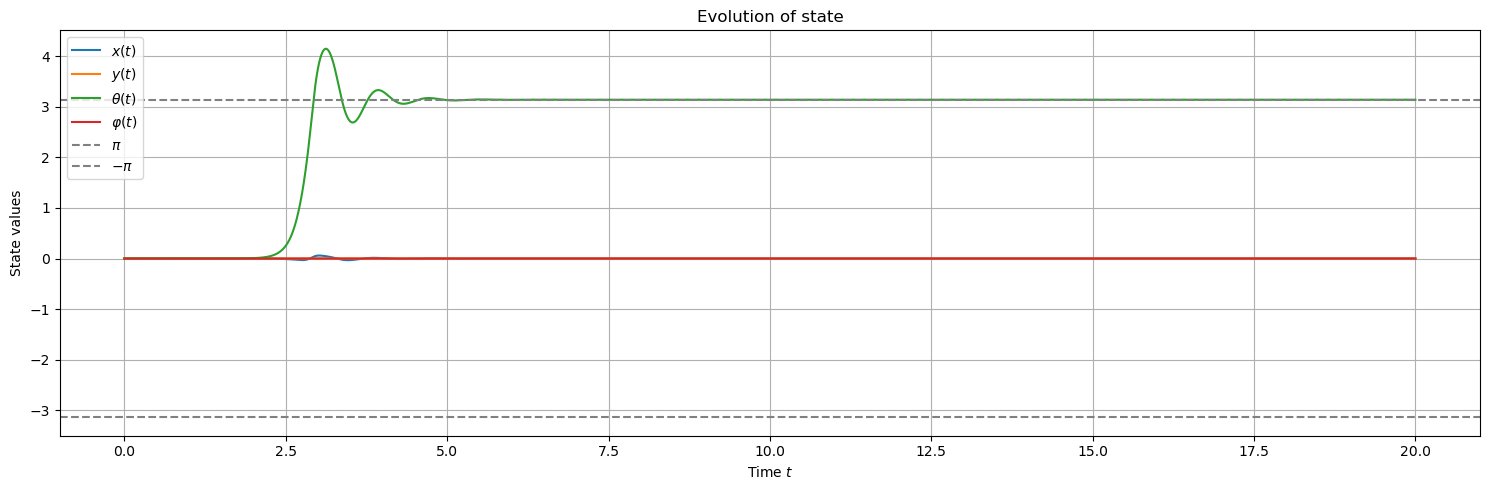

In [57]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_x, label=r'$x(t)$')
plt.plot(sol_t, sol_y, label=r'$y(t)$')
plt.plot(sol_t, sol_theta, label=r'$\theta(t)$')
plt.plot(sol_t, sol_phi, label=r'$\varphi(t)$')

plt.axhline(y=np.pi, linestyle='--', color='gray', label=r'$\pi$')
plt.axhline(y=-np.pi, linestyle='--', color='gray', label=r'$-\pi$')

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of state')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

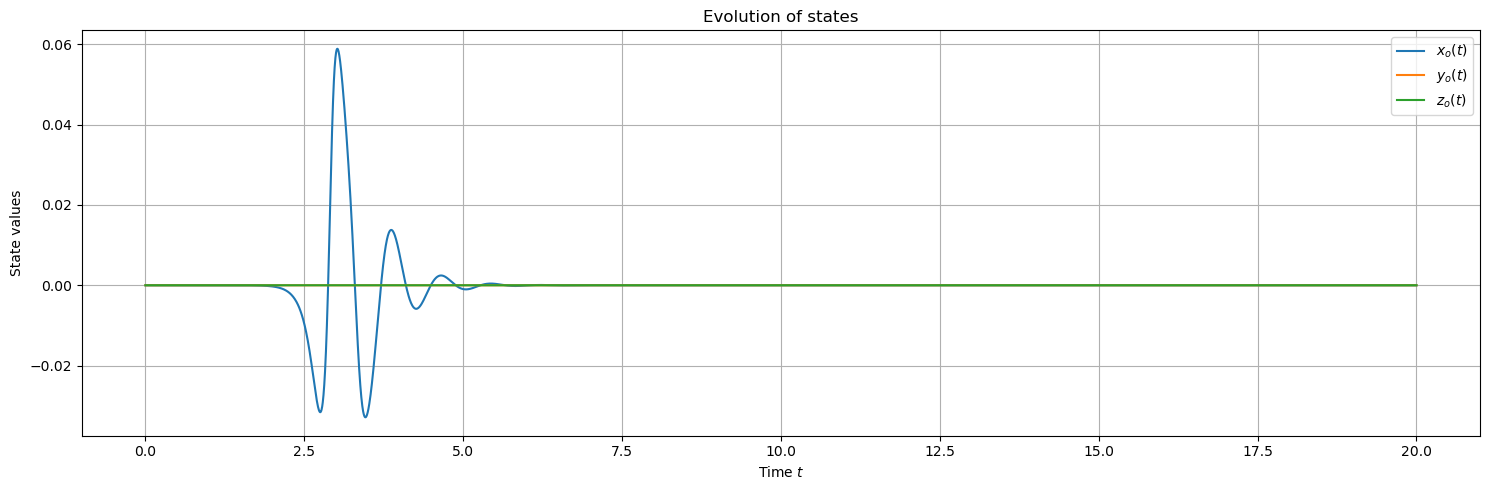

In [58]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_xo, label=[r'$x_o(t)$', r'$y_o(t)$', r'$z_o(t)$'])
# plt.plot(sol_t, sol_x, label=r'$x(t)$')

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

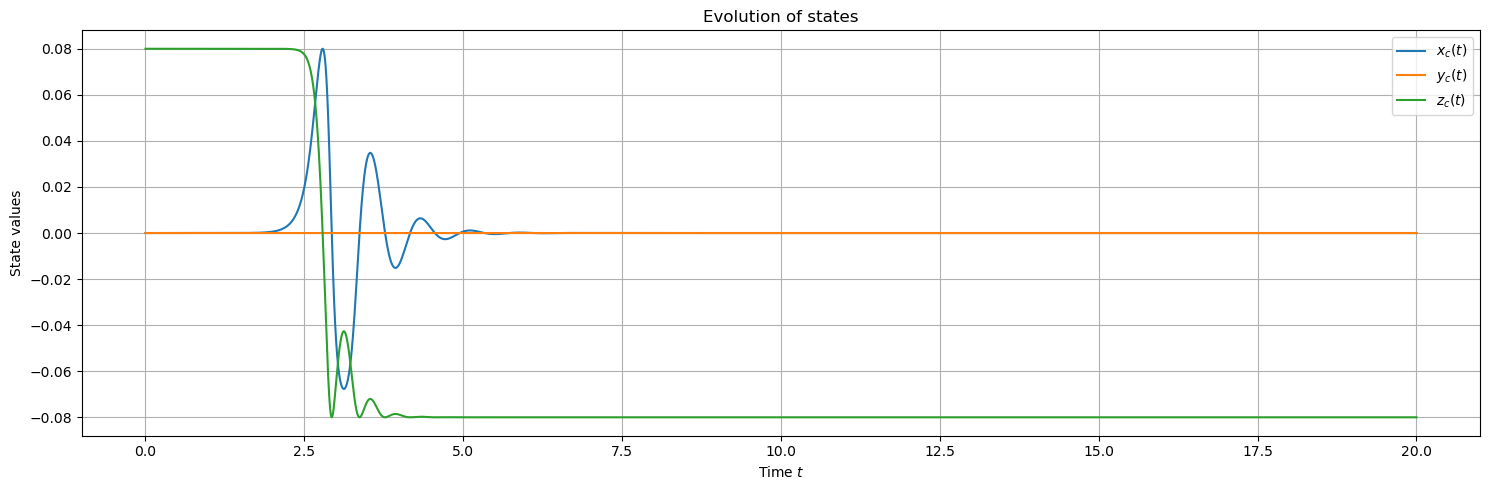

In [59]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_xc - sol_xo, label=[r'$x_c(t)$', r'$y_c(t)$', r'$z_c(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

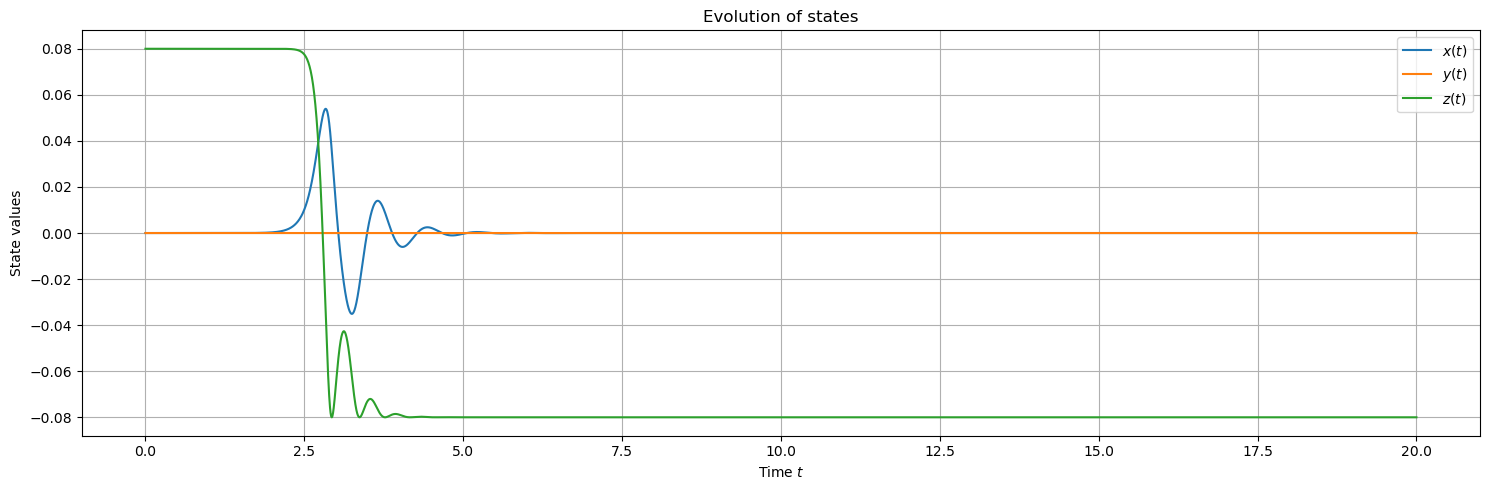

In [60]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_xc, label=[r'$x(t)$', r'$y(t)$', r'$z(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()